In [1]:
import warnings 
warnings.filterwarnings('ignore')

import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from catboost import Pool,CatBoostClassifier
from sklearn.metrics import roc_auc_score as AUC

import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
!ls ../input/*

pd.set_option('display.max_columns', 500)

../input/machine-failure-predictions:
'machine failure.csv'

../input/playground-series-s3e17:
sample_submission.csv  test.csv  train.csv

../input/ps321a:
'submission (3).csv'

../input/ps3e17s97778:
submission.csv

../input/ps3e17s97788:
submission.csv


In [2]:
df_train  = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv', index_col='id')
df_test   = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv', index_col='id')
df_sample = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')

# display(df_train , df_test, df_sample)
display(df_train.shape , df_test.shape, df_sample.shape)

(136429, 13)

(90954, 12)

(90954, 2)

### <span style="color:green;">Feature Engineering</span>

In [3]:
df_train.columns = df_train.columns.str.replace('[\[\]]', '', regex=True)
df_train["Power"] = df_train["Torque Nm"] * df_train["Rotational speed rpm"]
df_train["temp_ratio"] = df_train["Process temperature K"] / df_train["Air temperature K"]
df_train["Process temperature C"] = df_train["Process temperature K"] - 273.15
df_train["Air temperature C"] = df_train["Air temperature K"] - 273.15
df_train["temp_C_ratio"] = df_train["Process temperature C"] / df_train["Air temperature C"]
df_train["Failure Sum"] = (df_train["TWF"] +
                            df_train["HDF"] +
                            df_train["PWF"] +
                            df_train["OSF"] +
                            df_train["RNF"])
df_train["tool_wear_speed"] = df_train["Tool wear min"] * df_train["Rotational speed rpm"]
df_train["torque wear ratio"] = df_train["Torque Nm"] / (df_train["Tool wear min"] + 0.0001)
df_train["torque times wear"] = df_train["Torque Nm"] * df_train["Tool wear min"]


df_test.columns = df_test.columns.str.replace('[\[\]]', '', regex=True)
df_test["Power"] = df_test["Torque Nm"] * df_test["Rotational speed rpm"]
df_test["temp_ratio"] = df_test["Process temperature K"] / df_test["Air temperature K"]
df_test["Process temperature C"] = df_test["Process temperature K"] - 273.15
df_test["Air temperature C"] = df_test["Air temperature K"] - 273.15
df_test["temp_C_ratio"] = df_test["Process temperature C"] / df_test["Air temperature C"]
df_test["Failure Sum"] = (df_test["TWF"] +
                            df_test["HDF"] +
                            df_test["PWF"] +
                            df_test["OSF"] +
                            df_test["RNF"])
df_test["tool_wear_speed"] = df_test["Tool wear min"] * df_test["Rotational speed rpm"]
df_test["torque wear ratio"] = df_test["Torque Nm"] / (df_test["Tool wear min"] + 0.0001)
df_test["torque times wear"] = df_test["Torque Nm"] * df_test["Tool wear min"]


In [4]:
display(df_train.columns.tolist())

['Product ID',
 'Type',
 'Air temperature K',
 'Process temperature K',
 'Rotational speed rpm',
 'Torque Nm',
 'Tool wear min',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF',
 'Power',
 'temp_ratio',
 'Process temperature C',
 'Air temperature C',
 'temp_C_ratio',
 'Failure Sum',
 'tool_wear_speed',
 'torque wear ratio',
 'torque times wear']

In [5]:
# Original data
df_org = pd.read_csv('/kaggle/input/machine-failure-predictions/machine failure.csv')

pd.DataFrame(data= {'Number': df_org['Machine failure'].value_counts(), 
                    'Percent': df_org['Machine failure'].value_counts(normalize=True)})

,Number,Percent
0,9661,0.9661
1,339,0.0339


In [6]:
display(df_train.info())
# df_train.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Product ID             136429 non-null  object 
 1   Type                   136429 non-null  object 
 2   Air temperature K      136429 non-null  float64
 3   Process temperature K  136429 non-null  float64
 4   Rotational speed rpm   136429 non-null  int64  
 5   Torque Nm              136429 non-null  float64
 6   Tool wear min          136429 non-null  int64  
 7   Machine failure        136429 non-null  int64  
 8   TWF                    136429 non-null  int64  
 9   HDF                    136429 non-null  int64  
 10  PWF                    136429 non-null  int64  
 11  OSF                    136429 non-null  int64  
 12  RNF                    136429 non-null  int64  
 13  Power                  136429 non-null  float64
 14  temp_ratio             136429 non-nu

None

In [7]:
display(df_train.nunique())

Product ID                9976
Type                         3
Air temperature K           95
Process temperature K       81
Rotational speed rpm       952
Torque Nm                  611
Tool wear min              246
Machine failure              2
TWF                          2
HDF                          2
PWF                          2
OSF                          2
RNF                          2
Power                    48528
temp_ratio                2165
Process temperature C       81
Air temperature C           95
temp_C_ratio              2170
Failure Sum                  4
tool_wear_speed          52844
torque wear ratio        55448
torque times wear        37859
dtype: int64

### <span style="color:green;">Check Null Values</span>

In [8]:
MV1 = df_train.isnull().sum()
MV2 = df_test.isnull().sum()

print(':' * 25)
print(f'Missing Value df_train:\n{MV1[MV1 > 0]}')
print(':' * 25)
print(f'Missing Value df_test:\n{MV2[MV2 > 0]}')
print(':' * 25)

:::::::::::::::::::::::::
Missing Value df_train:
Series([], dtype: int64)
:::::::::::::::::::::::::
Missing Value df_test:
Series([], dtype: int64)
:::::::::::::::::::::::::


## <span style="color:green;">Train | Test | Target</span>
#### Let's see how unbalanced the dataset is:

,Number,Percent
0,134281,0.984256
1,2148,0.015744


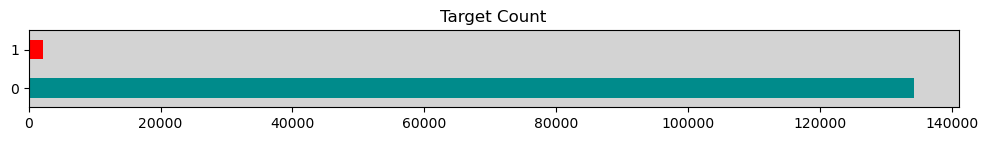

In [9]:
train  = df_train.copy()
test   = df_test.copy()
target = train.pop('Machine failure')

target.value_counts().plot(kind='barh', figsize=(12,1), title='Target Count', color=['darkcyan','red'])
plt.gca().set_facecolor('lightgray')

pd.DataFrame(data= {'Number': target.value_counts(), 'Percent': target.value_counts(normalize=True)})

## <span style="color:darkred;">Features</span>

In [10]:
features = train.columns.tolist()

# Categorical features
cat_features = ['Product ID', 'Type']

# Binary features
bin_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Numerical features
num_features = [f for f in features if f not in (cat_features + bin_features)]
              
print(':' * 40)
print('The number of Categorical_features:', len(cat_features)) 
print('The number of Binary_features:', len(bin_features))  
print('The number of Numerical_features:', len(num_features)) 
print(':' * 40)
print('The total number of features:', len(features))
print(':' * 40)

::::::::::::::::::::::::::::::::::::::::
The number of Categorical_features: 2
The number of Binary_features: 5
The number of Numerical_features: 14
::::::::::::::::::::::::::::::::::::::::
The total number of features: 21
::::::::::::::::::::::::::::::::::::::::


## <span style="color:green;">Categorical features</span>

In [11]:
for f in cat_features:
    
    print('\t' , f)
    n_f = train[f].value_counts()
    p_f = train[f].value_counts(normalize=True)
    display(pd.DataFrame(data= {'Number': n_f, 'Percent': p_f}))

	 Product ID


,Number,Percent
L53257,139,0.001019
L49056,131,0.000960
L53271,131,0.000960
L54275,120,0.000880
L48892,120,0.000880
...,...,...
M24614,1,0.000007
H39399,1,0.000007
M15853,1,0.000007
H32637,1,0.000007


	 Type


,Number,Percent
L,95354,0.698928
M,32152,0.235668
H,8923,0.065404


## <span style="color:green;">Binary features</span>

In [12]:
dfv = pd.DataFrame(data= {'Value': ['Number 0', 'Percent 0', '', 'Number 1', 'Percent 1']})

for f in bin_features: 
    n_f = train[f].value_counts()
    p_f = train[f].value_counts(normalize=True)
    dfv[f] = [n_f[0], p_f[0], '', n_f[1], p_f[1]]
    
dfv.set_index('Value')

,TWF,HDF,PWF,OSF,RNF
Value,,,,,
Number 0,136217,135725,136102,135889,136121
Percent 0,0.998446,0.99484,0.997603,0.996042,0.997742
,,,,,
Number 1,212,704,327,540,308
Percent 1,0.001554,0.00516,0.002397,0.003958,0.002258


## <span style="color:green;">Histograms of the Numerical features</span>

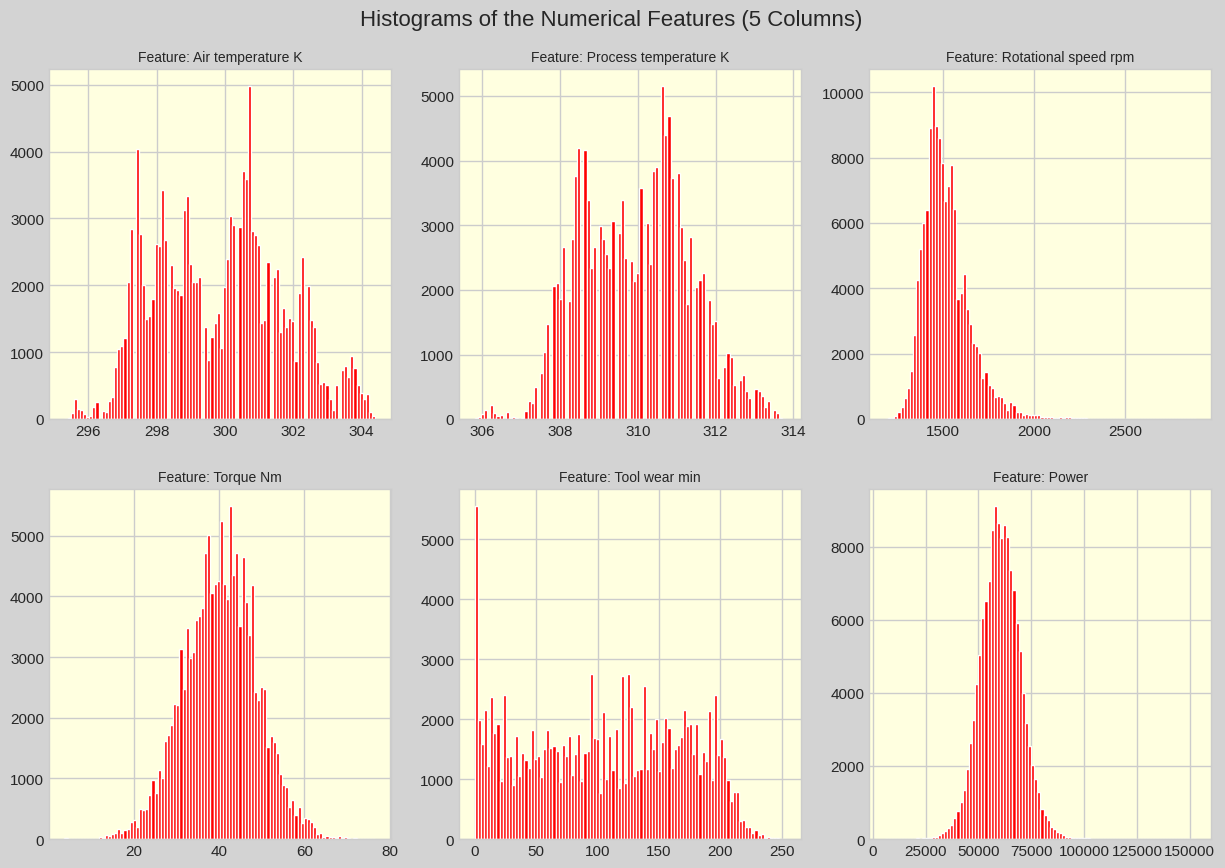

In [13]:
sns.set()
plt.style.use('seaborn-whitegrid') 
_, axs = plt.subplots(2, 3, figsize=(15,10), facecolor='lightgray')

for f, ax in zip(num_features, axs.ravel()):
    ax.set_facecolor('lightyellow')
    ax.hist(train[f], bins=100, color='red')
    ax.set_title(f'Feature: {f}', fontsize=10)

plt.suptitle('Histograms of the Numerical Features (5 Columns)', y=0.94, fontsize=16)
plt.show()

## <span style="color:darkred;">Correlation Matrix</span>

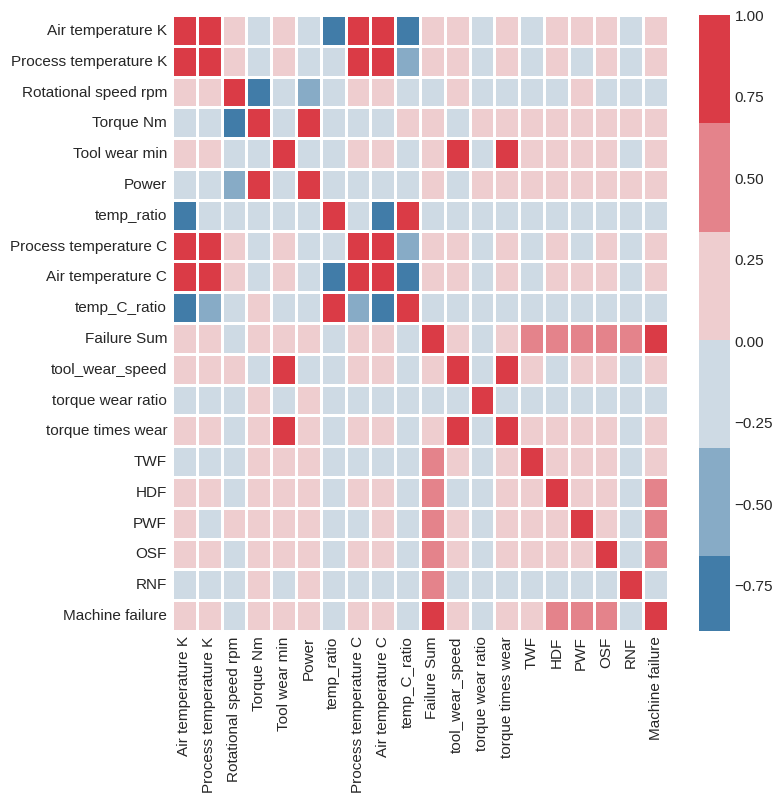

In [14]:
cor_matrix = df_train[num_features + bin_features  + ['Machine failure']].corr().round(2)
fig = plt.figure(figsize=(8,8));

plt.gca().set_facecolor('lightyellow')

cmap=sns.diverging_palette(240, 10, s=75, l=50, sep=1, n=6, center='light', as_cmap=False);
sns.heatmap(cor_matrix, center=0, annot=False, cmap=cmap, mask=False, linewidths=2);
plt.show()

In [15]:
corr = df_train[num_features + bin_features  + ['Machine failure']].corr(numeric_only=True)
corr.style.background_gradient(cmap='Blues')

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Power,temp_ratio,Process temperature C,Air temperature C,temp_C_ratio,Failure Sum,tool_wear_speed,torque wear ratio,torque times wear,TWF,HDF,PWF,OSF,RNF,Machine failure
Air temperature K,1.000000,0.856080,0.016545,-0.006773,0.016994,-0.004496,-0.718065,0.856080,1.000000,-0.887916,0.064574,0.018597,-0.000948,0.014314,0.003826,0.100454,0.007967,0.007842,0.004815,0.067744
Process temperature K,0.856080,1.000000,0.011263,-0.006298,0.012777,-0.004679,-0.255021,1.000000,0.856080,-0.524935,0.029612,0.013733,-0.004559,0.010579,0.004459,0.041454,0.003871,0.005337,0.004399,0.030966
Rotational speed rpm,0.016545,0.011263,1.000000,-0.779394,0.003983,-0.584267,-0.015718,0.011263,0.016545,-0.016258,-0.057100,0.151086,-0.025582,-0.247731,-0.005765,-0.081996,0.053948,-0.061376,-0.003410,-0.060868
Torque Nm,-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.952142,0.004150,-0.006298,-0.006773,0.005034,0.132825,-0.118359,0.027348,0.318195,0.012983,0.100773,0.050289,0.108765,0.007986,0.145793
Tool wear min,0.016994,0.012777,0.003983,-0.003148,1.000000,-0.003431,-0.014503,0.012777,0.016994,-0.015328,0.052961,0.984923,-0.270463,0.926409,0.046470,0.011709,0.007624,0.063604,-0.002071,0.056448
Power,-0.004496,-0.004679,-0.584267,0.952142,-0.003431,1.000000,0.002083,-0.004679,-0.004496,0.002917,0.115396,-0.090245,0.025498,0.301894,0.012258,0.076992,0.052033,0.099108,0.007361,0.128222
temp_ratio,-0.718065,-0.255021,-0.015718,0.004150,-0.014503,0.002083,1.000000,-0.255021,-0.718065,0.954630,-0.080509,-0.016207,-0.004360,-0.012464,-0.001132,-0.131452,-0.009629,-0.007421,-0.003082,-0.084591
Process temperature C,0.856080,1.000000,0.011263,-0.006298,0.012777,-0.004679,-0.255021,1.000000,0.856080,-0.524935,0.029612,0.013733,-0.004559,0.010579,0.004459,0.041454,0.003871,0.005337,0.004399,0.030966
Air temperature C,1.000000,0.856080,0.016545,-0.006773,0.016994,-0.004496,-0.718065,0.856080,1.000000,-0.887916,0.064574,0.018597,-0.000948,0.014314,0.003826,0.100454,0.007967,0.007842,0.004815,0.067744
temp_C_ratio,-0.887916,-0.524935,-0.016258,0.005034,-0.015328,0.002917,0.954630,-0.524935,-0.887916,1.000000,-0.075853,-0.016995,-0.002422,-0.013093,-0.002140,-0.122192,-0.008951,-0.007518,-0.003944,-0.079588


## <span style="color:green;">Evaluation Metric (AUC)</span>


In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def roc_auc(true_list, pred_list, a, b):
    
    fpr, tpr, _ = roc_curve(true_list, pred_list)    
    roc_auc = auc(fpr, tpr)

    # print(f'FPR: {fpr}')
    # print(f'TPR: {tpr}')
    # print(f'{list(zip(fpr,tpr))}') 
    print(f'\n>>>>> ROC_AUC: %0.6f <<<<<\n' %roc_auc)
    
    sns.set()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(a, b), facecolor='lightgray')
    plt.gca().set_facecolor('lightyellow')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The area under the ROC curve\n')
    plt.legend(loc="lower right")
    plt.show()


## <span style="color:darkcyan;">Data Preprocessing</span>



In [17]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

### <span style="color:green;">Scale the numerical features</span>

In [18]:
scaler = StandardScaler()

df_train[num_features] = scaler.fit_transform(df_train[num_features])
df_test[num_features] = scaler.fit_transform(df_test[num_features])

### <span style="color:green;">Columns Rename</span>

XGBoost doesn't work with column names that have "[" or "]" in them.

In [19]:
def fix_names(df):
    df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
    return df

df_train = fix_names(df_train)
df_test  = fix_names(df_test)

### <span style="color:green;">Dropping the feature: 'Product ID'</span>

This feature has 9976 different shapes and does not help in calculations.

In [20]:
display(pd.DataFrame(data= {'Number': df_train['Product ID'].value_counts(), 'Percent': df_train['Product ID'].value_counts(normalize=True)}))

,Number,Percent
L53257,139,0.001019
L49056,131,0.000960
L53271,131,0.000960
L54275,120,0.000880
L48892,120,0.000880
...,...,...
M24614,1,0.000007
H39399,1,0.000007
M15853,1,0.000007
H32637,1,0.000007


In [21]:
df_train = df_train.drop(['Product ID'] , axis=1)
df_test = df_test.drop(['Product ID'] , axis=1)

In [22]:
df_train.shape

(136429, 21)

### <span style="color:green;">Convert Categorical features</span>

The first method: pandas.get_dummies (OneHotEncoder)

In [23]:
features = df_train.columns.tolist()
features.remove('Machine failure')

# Categorical features
cat_features = ['Type']

# Binary features
bin_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Numerical features
num_features = [f for f in features if f not in (cat_features + bin_features)]

In [24]:
train_code = pd.get_dummies(df_train, columns=cat_features)
test_code = pd.get_dummies(df_test, columns=cat_features)
target = train_code.pop('Machine failure')

train_code.shape, test_code.shape, target.shape

((136429, 22), (90954, 22), (136429,))

In [25]:
new_features=train_code.columns.to_list()


In [26]:
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer

CatBoost

In [27]:
params ={'loss_function': 'Logloss',
         'eval_metric': 'AUC',
         'random_seed': 19970507,
         'learning_rate': 0.027, 
          'iterations': 927, 
          'depth': 5, 
          'subsample': 0.705}

train_pool = Pool(train_code.to_numpy(), target.to_numpy(), 
                  feature_names=new_features)

model = CatBoostClassifier()

model.fit(train_pool, eval_set=train_pool, verbose=False, plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
train_auc = AUC(target, model.predict(train_code))
print(f"Train Score: {train_auc}")

Train Score: 0.927806339209432


In [29]:
test_pool = Pool(test_code.to_numpy(), 
                 feature_names=new_features)
pred = model.predict_proba(test_pool)[:, 1]
pred

array([0.00184389, 0.00046861, 0.00312221, ..., 0.00205389, 0.00147637,
       0.001676  ])

In [30]:
sub_cat = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')
sub_cat['Machine failure'] = pred
sub_cat.to_csv('submission_cat.csv',index=False)
!ls

__notebook__.ipynb  catboost_info  submission_cat.csv


LightGBM

In [31]:
from sklearn.model_selection import StratifiedKFold

sk = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
df_fold = pd.DataFrame()
df_fold["fold"] = np.zeros(len(df_train))
for k, (train_idx, val_idx) in enumerate(sk.split(df_train, df_train['Machine failure'])):
    df_fold.loc[val_idx, "fold"] = k

df_fold["fold"] = df_fold["fold"].astype(int)

In [32]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
class LGBMBuilder:
    def __init__(self, opt=False):
        self.config = {
            'reg_alpha': 9.447560026770628,   # MAGIC NUMBER :) (founded with Optuna HPO)
            'reg_lambda': 1.56941300531116,   # MAGIC NUMBER :) (founded with Optuna HPO)
            'metric': 'auc',
            'objective': 'binary',
            'boosting_type': 'gbdt',
        }

    def set_opt_config(self, trial):
        config = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            'metric': 'auc',
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        }
        self.config = config

    def new_model(self):
        self.model = lgbm.LGBMClassifier(**self.config)
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.model.fit(X, y)

    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1].flatten()
    

In [33]:
def train(model_builder, df, df_fold):
    scores = []
    models = []

    for fold in range(10):
        val_idx = df_fold["fold"] == fold
        train_idx = df_fold["fold"] != fold
        df_train = df.loc[train_idx, :]
        df_val = df.loc[val_idx, :]

        y_train = target[train_idx]
        y_val = target[val_idx]

        # Training and Eval
        model_builder.new_model()
        model_builder.fit(df_train, y_train, df_val, y_val)
        y_pred = model_builder.predict_proba(df_val)
        score = roc_auc_score(y_val, y_pred)
        print(f"fold {fold} - AUC {score:.5f}")

        scores.append(score)
        models.append(model_builder)

    cv_score = np.mean(scores)

    print("CV", cv_score)
    
    return models, cv_score

In [34]:
model_builder = LGBMBuilder()
models, score = train(model_builder, train_code, df_fold)

fold 0 - AUC 0.95883
fold 1 - AUC 0.96962
fold 2 - AUC 0.96841
fold 3 - AUC 0.96619
fold 4 - AUC 0.97467
fold 5 - AUC 0.96577
fold 6 - AUC 0.96002
fold 7 - AUC 0.97058
fold 8 - AUC 0.95376
fold 9 - AUC 0.95873
CV 0.9646579621237115


In [35]:
y_test = 0
for m in models:
    y_test = m.predict_proba(test_code)

y_test /= len(models)

In [36]:
df_sub = pd.DataFrame()

# read the test another time to get the id
df_test = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
df_sub["id"] = df_test["id"]
df_sub["Machine failure"] = y_test
df_sub.to_csv("submission_lgb.csv", index=False)

## <span style="color:darkred;">Ensembling & Submission</span>

Thanks to: **@tetsutani**  
https://www.kaggle.com/code/tetsutani/ps3e17-eda-ensemble-ml-pipeline-shap

Thanks to: **@jimmyyeung**  
https://www.kaggle.com/code/jimmyyeung/ps3-17-machine-failure-catboost-top-21

In [37]:
sub_import1 = pd.read_csv('/kaggle/input/ps3e17s97778/submission.csv')
sub_import2 = pd.read_csv('/kaggle/input/ps3e17s97788/submission.csv')
sub_import3 = pd.read_csv('/kaggle/input/ps321a/submission (3).csv')

In [38]:
sub = df_sample.copy()
sub['Machine failure'] = ((0.05* sub_cat['Machine failure']) + (0.1 * sub_import1['Machine failure']) + 
                         (1.7 * sub_import2['Machine failure'])+ (0.1 * sub_import3['Machine failure']) +
                         (0.05 * df_sub['Machine failure']))/(2)
                         
sub.to_csv('submission.csv',index=False)
!ls

__notebook__.ipynb  submission.csv	submission_lgb.csv
catboost_info	    submission_cat.csv
